# Imports

In [1]:
%matplotlib inline
import ast
import os
import matplotlib.pyplot as plt
import numpy as np

from qiskit.result import QuasiDistribution

# Get Data for Simon's Algorithm Experiment

In [2]:
def getData(
        directory, isReversed, isProbFormat, shots, isSimple=False
    ):
    '''
    A function to evaluate and plot an error line for a device.
    Parameters:
        directory (string)      : The name of the directory to extract and plot.
        isReversed (Boolean)    : Indicates if the result strings are inverted.
        isProbFormat (Boolean)  : Indicates if frequencies are probabilities.
        shots (int)             : The number of times each job was repeated.
        isSimple (string)       : Specifies the complexity of the oracle.
    '''

    # Initialize empty needed variables.
    errorArray = np.zeros(100)
    iterations = 0

    # For each file in the directory:
    for filename in os.listdir(directory):

        # Initialize empty needed variables.
        resultsDict = None
        errorCount = 0

        # Extract the number of qubits and iteration number from the filename.
        numQubits = int(filename[1:filename.find('i')])
        iteration = int(filename[filename.find('i')+1:-4])

        # Update the maximum iteration if needed.
        if iteration > iterations:
            iterations = iteration
            
        # Compose the secret key from the number of qubits.
        secretKey = '1' * numQubits
        if isSimple:
            secretKey = '0' * (numQubits - 1) + '1'

        # Read the data from the working file.
        file = os.path.join(directory, filename)
        with open(file, 'r') as fin:
            data = fin.read()

        # If this file is in probability format:
        if isProbFormat:

            # Extract the data and obtain the nearest probability distribution.
            extractedData = ast.literal_eval(data)
            if type(extractedData) == list:
                extractedData = extractedData[0]
            quasiDist = QuasiDistribution(extractedData, shots=shots)
            resultsDict = quasiDist.nearest_probability_distribution()
            resultsDict = resultsDict.binary_probabilities()

            # Assert that the probabilities sum to unity (approximately).
            probSum = 0
            for result, prob in resultsDict.items():
                probSum += prob
            assert abs(probSum-1) <= 0.0001, f'Probability incorrect: {probSum}, {directory}'

        # Otherwise if this file is not in probability format:
        else:
            
            # Extract the data as is.
            resultsDict = ast.literal_eval(data)

        # For each key-value pair in the data:
        for result, frequency in resultsDict.items():

            # Extract the secret key (reversing if necessary).
            key = result[numQubits:]
            if isReversed:
                result = result[::-1]

            # Identify if the extracted key is orthogonal to the secret key.
            isOrthogonal = (
                sum([
                    int(key[i]) * int(secretKey[i]) for i in range(numQubits)
                ]) % 2
            ) == 0

            # Increment the error count for strings that are not orthogonal.
            if not isOrthogonal:
                errorCount += frequency

        # Finally, update the error count with the data from the file.
        errorArray[int(numQubits) - 2] += errorCount

    # Normalize the error counts by dividing by the number of iterations.
    if isProbFormat:
        errorArray /= iterations
    else:
        errorArray /= (shots * iterations)

    # Trim the error array and create a qubit count array of the proper size.
    errorArray = np.trim_zeros(errorArray)
    qubitCounts = np.arange(4, 2*len(errorArray)+3, 2)

    return qubitCounts, errorArray

In [3]:
deviceNames = [
    'IBM Brisbane',
    'IBM Brisbane Simulator',
    'IBM Osaka',
    'IBM Osaka Simulator',
    'IBM Kyoto',
    'IBM Kyoto Simulator',
    'IonQ Harmony',
    'IonQ Harmony Simulator',
    'IonQ Aria',
    'IonQ Aria Simulator',
    'IonQ Forte'
]

data = {}
for deviceName in deviceNames:
    # Define the inputs for the plotLine function.
    directory = 'data/' + deviceName.replace(' ', '')
    isReversed = True if 'IBM' in deviceName else False
    isProbabilityFormat = True if (
        'IBM' in deviceName or 'Aria' in deviceName
    ) and not 'Simulator' in deviceName else False
    shots = 8192 if not 'Forte' in deviceName else 4096

    data[deviceName] = getData(directory, isReversed, isProbabilityFormat, shots)

In [4]:
additionalExperiments = [
    'IBM Osaka Post Update',
    'IBM Osaka Simulator Post Update',
    'IBM Brisbane Simple',
    'IBM Brisbane Simulator Simple',
    'IBM Osaka Simple',
    'IBM Osaka Simulator Simple',
    'IBM Kyoto Simple',
    'IBM Kyoto Simulator Simple'
]

for experimentName in additionalExperiments:
    # Define the inputs for the plotLine function.
    directory = 'data/' + experimentName.replace(' ', '')
    isReversed = True
    isProbabilityFormat = False
    shots = 8192
    isSimple = True if ('Simple' in experimentName) else False

    data[experimentName] = getData(directory, isReversed, isProbabilityFormat, shots, isSimple)

# Construct Plots for Simon's Algorithm Experiment

In [5]:
def _do_plot(the_ax, ns, es, **kwargs):
    the_ax.plot(ns, es, **kwargs)

In [6]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.titlesize']  = 11
plt.rcParams['axes.labelsize']  = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9

Text(0, 0.5, 'Fraction of Invalid Outputs')

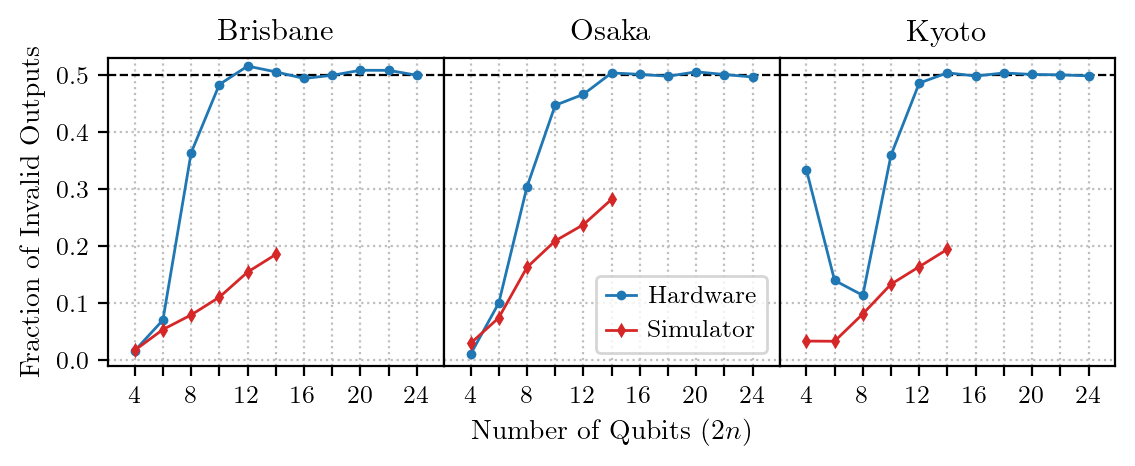

In [7]:
fig, ax = plt.subplots(ncols=3, figsize=(6.5, 2), dpi=200, sharex=True, sharey=True)

fig.subplots_adjust(wspace=0)

_plot_args_expt = {
    'color': 'C0',
    'marker': 'o',
    'linewidth': 1,
    'markersize': 2.5,
    'label': 'Hardware'
}

_plot_args_sim = _plot_args_expt.copy()
_plot_args_sim['color'] = 'C3'
_plot_args_sim['marker'] = 'd'
_plot_args_sim['label'] = 'Simulator'

ax[0].set_xlim(2.1, 25.9)
ax[0].set_ylim(-0.01, 0.53)
ax[0].set_yticks(np.arange(0, 0.51, 0.1))
ax[0].set_xticks(np.arange(4, 24+1, 2))

ax[1].yaxis.set_ticks_position('none') 
ax[2].yaxis.set_ticks_position('none') 

ax[0].set_xticklabels([str(nq) if nq % 4 == 0 else "" for nq in range(4, 24+1, 2)])

ax[0].grid(color='0.75', linestyle=':')
ax[1].grid(color='0.75', linestyle=':')
ax[2].grid(color='0.75', linestyle=':')

ax[0].axhline(0.5, color='black', linestyle='--', linewidth=0.8)
ax[1].axhline(0.5, color='black', linestyle='--', linewidth=0.8)
ax[2].axhline(0.5, color='black', linestyle='--', linewidth=0.8)

_do_plot(ax[0], *data['IBM Brisbane'], **_plot_args_expt)
_do_plot(ax[0], *data['IBM Brisbane Simulator'], **_plot_args_sim)

_do_plot(ax[1], *data['IBM Osaka'], **_plot_args_expt)
_do_plot(ax[1], *data['IBM Osaka Simulator'], **_plot_args_sim)

_do_plot(ax[2], *data['IBM Kyoto'], **_plot_args_expt)
_do_plot(ax[2], *data['IBM Kyoto Simulator'], **_plot_args_sim)

ax[1].legend(handletextpad=0.5, handlelength=1.2)

ax[0].set_title("Brisbane")
ax[1].set_title("Osaka")
ax[2].set_title("Kyoto")

ax[1].set_xlabel("Number of Qubits ($2n$)")
ax[0].set_ylabel("Fraction of Invalid Outputs")

In [8]:
fig.savefig("IBMComparisonTest.pdf", format='pdf', bbox_inches='tight')

Text(0, 0.5, 'Fraction of Invalid Outputs')

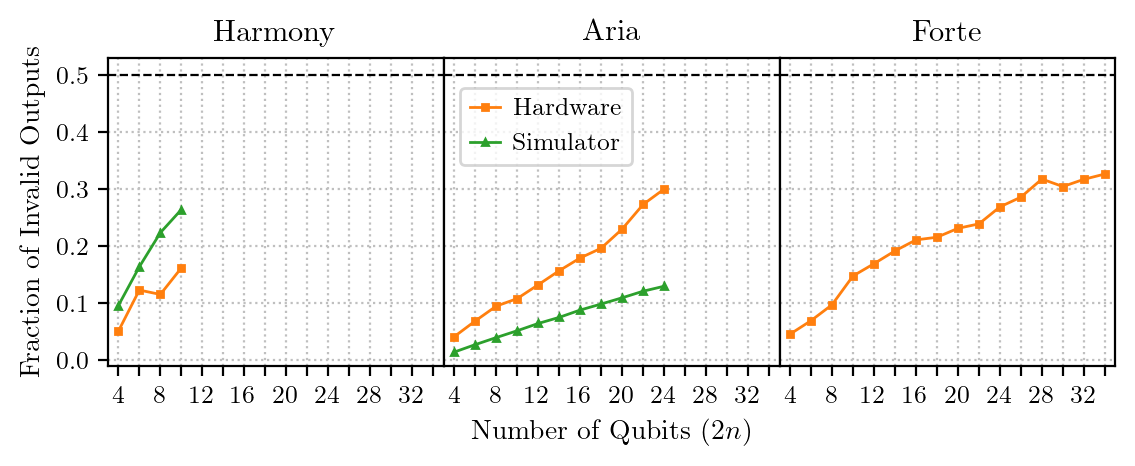

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(6.5, 2), dpi=200, sharex=True, sharey=True)

fig.subplots_adjust(wspace=0)

_plot_args_expt = {
    'color': 'C1',
    'marker': 's',
    'linewidth': 1,
    'markersize': 2.5,
    'label': 'Hardware'
}

_plot_args_sim = _plot_args_expt.copy()
_plot_args_sim['color'] = 'C2'
_plot_args_sim['marker'] = '^'
_plot_args_sim['label'] = 'Simulator'

ax[0].set_xlim(3, 35)
ax[0].set_ylim(-0.01, 0.53)
ax[0].set_yticks(np.arange(0, 0.51, 0.1))
ax[0].set_xticks(np.arange(4, 34+1, 2))

ax[1].yaxis.set_ticks_position('none') 
ax[2].yaxis.set_ticks_position('none') 

ax[0].set_xticklabels([str(nq) if nq % 4 == 0 else "" for nq in range(4, 34+1, 2)])

ax[0].grid(color='0.75', linestyle=':')
ax[1].grid(color='0.75', linestyle=':')
ax[2].grid(color='0.75', linestyle=':')

ax[0].axhline(0.5, color='black', linestyle='--', linewidth=0.8)
ax[1].axhline(0.5, color='black', linestyle='--', linewidth=0.8)
ax[2].axhline(0.5, color='black', linestyle='--', linewidth=0.8)

_do_plot(ax[0], *data['IonQ Harmony'], **_plot_args_expt)
_do_plot(ax[0], *data['IonQ Harmony Simulator'], **_plot_args_sim)

_do_plot(ax[1], *data['IonQ Aria'], **_plot_args_expt)
_do_plot(ax[1], *data['IonQ Aria Simulator'], **_plot_args_sim)

_do_plot(ax[2], *data['IonQ Forte'], **_plot_args_expt)

ax[1].legend(loc=(0.05, 0.65), handletextpad=0.5, handlelength=1.2)

ax[0].set_title("Harmony")
ax[1].set_title("Aria")
ax[2].set_title("Forte")

ax[1].set_xlabel("Number of Qubits ($2n$)")
ax[0].set_ylabel("Fraction of Invalid Outputs")

In [10]:
fig.savefig("IonQComparisonTest.pdf", format='pdf', bbox_inches='tight')

Text(0, 0.5, 'Fraction of Invalid Outputs')

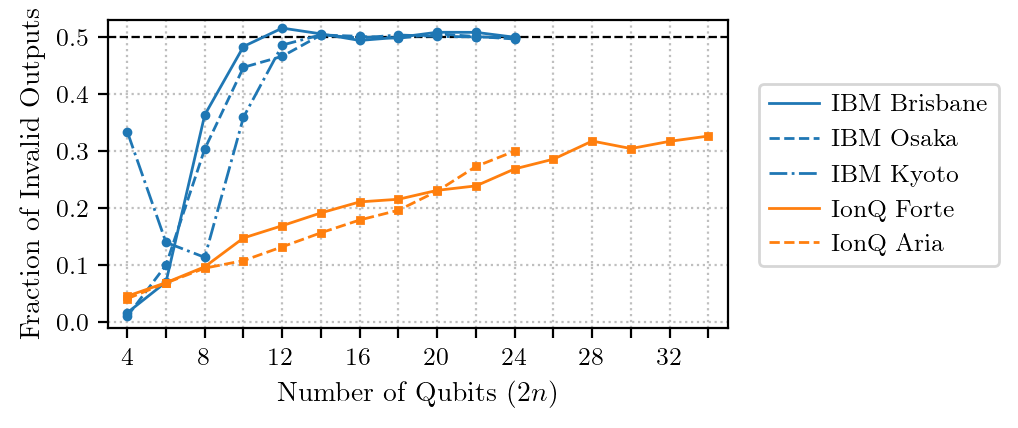

In [11]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=200)

_plot_args_ibm = {
    'color': 'C0',
    'marker': 'o',
    'linewidth': 1,
    'markersize': 2.5,
}

_plot_args_ionq = _plot_args_ibm.copy()
_plot_args_ionq['color'] = 'C1'
_plot_args_ionq['marker'] = 's'

ax.set_xlim(3, 35)
ax.set_ylim(-0.01, 0.53)
ax.set_yticks(np.arange(0, 0.51, 0.1))
ax.set_xticks(np.arange(4, 34+1, 2))
ax.set_xticklabels([str(nq) if nq % 4 == 0 else "" for nq in range(4, 34+1, 2)])

ax.grid(color='0.75', linestyle=':')

ax.axhline(0.5, color='black', linestyle='--', linewidth=0.8)

_do_plot(ax, *data['IBM Brisbane'], **_plot_args_ibm, linestyle='-', label="IBM Brisbane")
_do_plot(ax, *data['IBM Osaka'], **_plot_args_ibm, linestyle='--', label="IBM Osaka")
_do_plot(ax, *data['IBM Kyoto'], **_plot_args_ibm, linestyle='-.', label="IBM Kyoto")

_do_plot(ax, *data['IonQ Forte'], **_plot_args_ionq, linestyle='-', label="IonQ Forte")
_do_plot(ax, *data['IonQ Aria'], **_plot_args_ionq, linestyle='--', label="IonQ Aria")

ax.legend(loc=(1.05, 0.2), handletextpad=0.5, handlelength=2.0, markerscale=0)

ax.set_xlabel("Number of Qubits ($2n$)")
ax.set_ylabel("Fraction of Invalid Outputs")

In [12]:
fig.savefig("IBMIonQComparisonTest.pdf", format='pdf', bbox_inches='tight')

Text(0, 0.5, 'Fraction of Invalid Outputs')

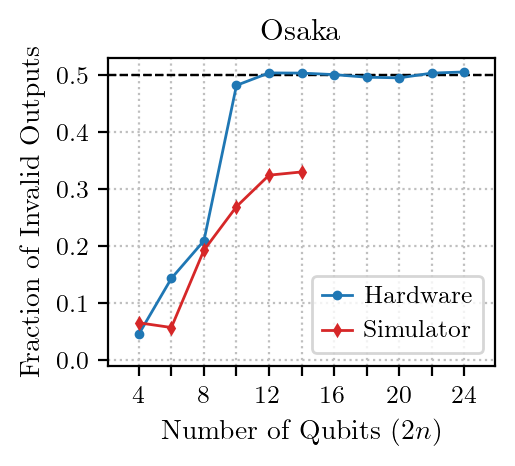

In [13]:
fig, ax = plt.subplots(ncols=1, figsize=(2.5, 2), dpi=200, sharex=True, sharey=True)

fig.subplots_adjust(wspace=0)

_plot_args_expt = {
    'color': 'C0',
    'marker': 'o',
    'linewidth': 1,
    'markersize': 2.5,
    'label': 'Hardware'
}

_plot_args_sim = _plot_args_expt.copy()
_plot_args_sim['color'] = 'C3'
_plot_args_sim['marker'] = 'd'
_plot_args_sim['label'] = 'Simulator'

ax.set_xlim(2.1, 25.9)
ax.set_ylim(-0.01, 0.53)
ax.set_yticks(np.arange(0, 0.51, 0.1))
ax.set_xticks(np.arange(4, 24+1, 2))

ax.set_xticklabels([str(nq) if nq % 4 == 0 else "" for nq in range(4, 24+1, 2)])

ax.grid(color='0.75', linestyle=':')

ax.axhline(0.5, color='black', linestyle='--', linewidth=0.8)
ax.grid(color='0.75', linestyle=':')
ax.axhline(0.5, color='black', linestyle='--', linewidth=0.8)

_do_plot(ax, *data['IBM Osaka Post Update'], **_plot_args_expt)
_do_plot(ax, *data['IBM Osaka Simulator Post Update'], **_plot_args_sim)

ax.legend(handletextpad=0.5, handlelength=1.2)

ax.set_title("Osaka")

ax.set_xlabel("Number of Qubits ($2n$)")
ax.set_ylabel("Fraction of Invalid Outputs")

In [14]:
fig.savefig("IBMOsakaPostUpdate.pdf", format='pdf', bbox_inches='tight')

Text(0, 0.5, 'Fraction of Invalid Outputs')

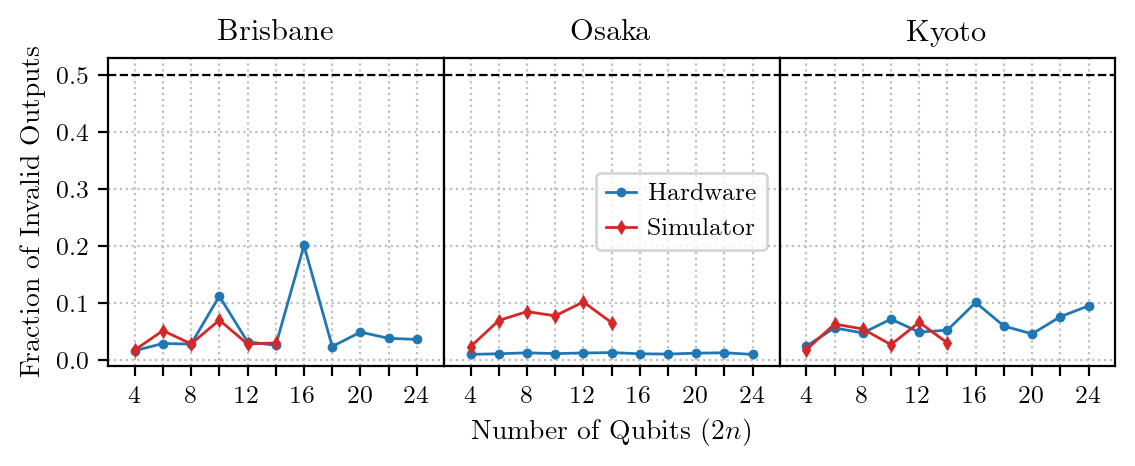

In [15]:
fig, ax = plt.subplots(ncols=3, figsize=(6.5, 2), dpi=200, sharex=True, sharey=True)

fig.subplots_adjust(wspace=0)

_plot_args_expt = {
    'color': 'C0',
    'marker': 'o',
    'linewidth': 1,
    'markersize': 2.5,
    'label': 'Hardware'
}

_plot_args_sim = _plot_args_expt.copy()
_plot_args_sim['color'] = 'C3'
_plot_args_sim['marker'] = 'd'
_plot_args_sim['label'] = 'Simulator'

ax[0].set_xlim(2.1, 25.9)
ax[0].set_ylim(-0.01, 0.53)
ax[0].set_yticks(np.arange(0, 0.51, 0.1))
ax[0].set_xticks(np.arange(4, 24+1, 2))

ax[1].yaxis.set_ticks_position('none') 
ax[2].yaxis.set_ticks_position('none') 

ax[0].set_xticklabels([str(nq) if nq % 4 == 0 else "" for nq in range(4, 24+1, 2)])

ax[0].grid(color='0.75', linestyle=':')
ax[1].grid(color='0.75', linestyle=':')
ax[2].grid(color='0.75', linestyle=':')

ax[0].axhline(0.5, color='black', linestyle='--', linewidth=0.8)
ax[1].axhline(0.5, color='black', linestyle='--', linewidth=0.8)
ax[2].axhline(0.5, color='black', linestyle='--', linewidth=0.8)

_do_plot(ax[0], *data['IBM Brisbane Simple'], **_plot_args_expt)
_do_plot(ax[0], *data['IBM Brisbane Simulator Simple'], **_plot_args_sim)

_do_plot(ax[1], *data['IBM Osaka Simple'], **_plot_args_expt)
_do_plot(ax[1], *data['IBM Osaka Simulator Simple'], **_plot_args_sim)

_do_plot(ax[2], *data['IBM Kyoto Simple'], **_plot_args_expt)
_do_plot(ax[2], *data['IBM Kyoto Simulator Simple'], **_plot_args_sim)

ax[1].legend(handletextpad=0.5, handlelength=1.2)

ax[0].set_title("Brisbane")
ax[1].set_title("Osaka")
ax[2].set_title("Kyoto")

ax[1].set_xlabel("Number of Qubits ($2n$)")
ax[0].set_ylabel("Fraction of Invalid Outputs")

In [16]:
fig.savefig("IBMSimple.pdf", format='pdf', bbox_inches='tight')

# Get Data for CNOT Experiment

In [17]:
def getDataCNOT(
        directory, shots
    ):
    '''
    A function to evaluate and plot an error line for a device.
    Parameters:
        directory (string)      : The name of the directory to extract and plot.
        shots (int)             : The number of times each job was repeated.
    '''

    # Initialize empty needed variables.
    errorArray = np.zeros(100)
    iterations = 0

    # For each file in the directory:
    for filename in os.listdir(directory):

        # Initialize empty needed variables.
        resultsDict = None
        errorCount = 0

        # Extract the CNOT distance and iteration number from the filename.
        distance = int(filename[1:filename.find('i')]) - 39
        iteration = int(filename[filename.find('i')+1:-4])

        # Update the maximum iteration if needed.
        if iteration > iterations:
            iterations = iteration
            
        # Compose the secret key. Note that the IBM convention is assumed.
        secretKey = '11'

        # Read the data from the working file.
        file = os.path.join(directory, filename)
        with open(file, 'r') as fin:
            data = fin.read()
            
        # Extract the data.
        resultsDict = ast.literal_eval(data)

        # For each key-value pair in the data:
        for key, frequency in resultsDict.items():

            # Increment the error count for strings that are not orthogonal.
            if key != secretKey:
                errorCount += frequency

        # Finally, update the error count with the data from the file.
        errorArray[distance] += errorCount

    # Normalize the error counts by dividing by the number of iterations.
    errorArray /= (shots * iterations)

    # Trim the error array and create a qubit count array of the proper size.
    errorArray = np.trim_zeros(errorArray)
    qubitCounts = np.arange(0, len(errorArray))

    return qubitCounts, errorArray

In [18]:
cnotExperiments = [
    'IBM Brisbane',
    'IBM Brisbane Simulator',
    'IBM Osaka',
    'IBM Osaka Simulator',
    'IBM Kyoto',
    'IBM Kyoto Simulator'
]

dataCNOT = {}
for experimentName in cnotExperiments:
    # Define the inputs for the plotLine function.
    directory = 'cnotData/' + experimentName.replace(' ', '')
    isReversed = True
    isProbabilityFormat = False
    shots = 8192
    oracleType = 'cnot'

    dataCNOT[experimentName] = getDataCNOT(directory, shots)

# Construct Plots for CNOT Experiment

Text(0, 0.5, 'Fraction of Invalid Outputs')

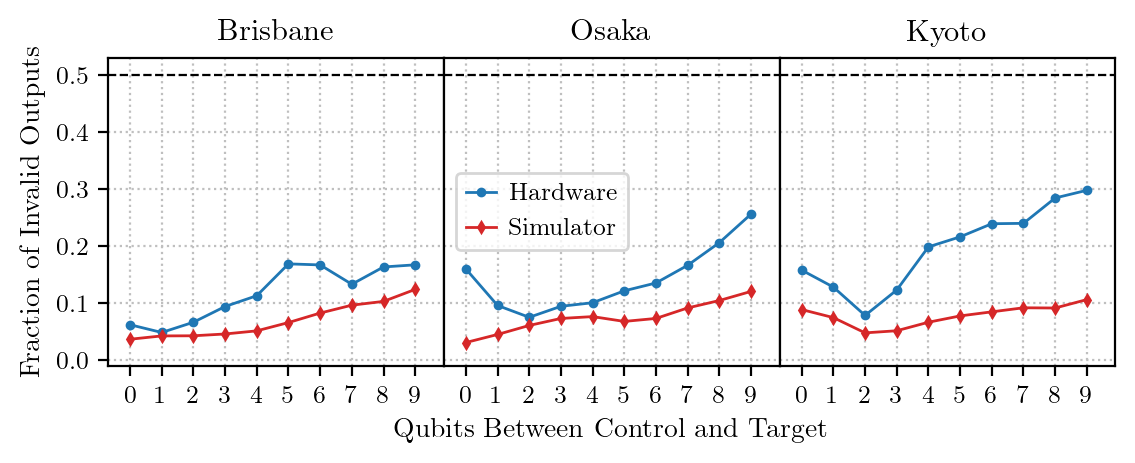

In [19]:
fig, ax = plt.subplots(ncols=3, figsize=(6.5, 2), dpi=200, sharex=True, sharey=True)

fig.subplots_adjust(wspace=0)

_plot_args_expt = {
    'color': 'C0',
    'marker': 'o',
    'linewidth': 1,
    'markersize': 2.5,
    'label': 'Hardware'
}

_plot_args_sim = _plot_args_expt.copy()
_plot_args_sim['color'] = 'C3'
_plot_args_sim['marker'] = 'd'
_plot_args_sim['label'] = 'Simulator'

ax[0].set_xlim(-0.7, 9.9)
ax[0].set_ylim(-0.01, 0.53)
ax[0].set_yticks(np.arange(0, 0.51, 0.1))
ax[0].set_xticks(np.arange(0, 9+1, 1))

ax[1].yaxis.set_ticks_position('none') 
ax[2].yaxis.set_ticks_position('none') 

ax[0].grid(color='0.75', linestyle=':')
ax[1].grid(color='0.75', linestyle=':')
ax[2].grid(color='0.75', linestyle=':')

ax[0].axhline(0.5, color='black', linestyle='--', linewidth=0.8)
ax[1].axhline(0.5, color='black', linestyle='--', linewidth=0.8)
ax[2].axhline(0.5, color='black', linestyle='--', linewidth=0.8)

_do_plot(ax[0], *dataCNOT['IBM Brisbane'], **_plot_args_expt)
_do_plot(ax[0], *dataCNOT['IBM Brisbane Simulator'], **_plot_args_sim)

_do_plot(ax[1], *dataCNOT['IBM Osaka'], **_plot_args_expt)
_do_plot(ax[1], *dataCNOT['IBM Osaka Simulator'], **_plot_args_sim)

_do_plot(ax[2], *dataCNOT['IBM Kyoto'], **_plot_args_expt)
_do_plot(ax[2], *dataCNOT['IBM Kyoto Simulator'], **_plot_args_sim)

ax[1].legend(handletextpad=0.5, handlelength=1.2)

ax[0].set_title("Brisbane")
ax[1].set_title("Osaka")
ax[2].set_title("Kyoto")

ax[1].set_xlabel("Qubits Between Control and Target")
ax[0].set_ylabel("Fraction of Invalid Outputs")

In [20]:
fig.savefig("IBMCnotTest.pdf", format='pdf', bbox_inches='tight')